# 學習日期: 2022/6/2開始
## 目標: 使用指定的backbone論文，進行口罩辨識
## Backbone論文: Network in Network
- **參考資料1:** https://hackmd.io/@shaoeChen/HJ19NfW4U
- **參考資料2:** https://github.com/jiecaoyu/pytorch-nin-cifar10
- **長青自製-口罩數據集:** https://drive.google.com/drive/folders/1lC_BVKHzEbtMEy8tibXAsJdrAs6fWuz5?usp=sharing


## 0_修改程式 (傳送門)
- [1_設定參數](#1_設定參數)


- [2.1_資料前處理-transform](#2.1_資料前處理-transform)


- [2.2_資料前處理-資料分割方式](#2.2_資料前處理-資料分割方式)


- [3.1_查看model參數量](#3.1_查看model參數量)


- [3.2_訓練模型(train,val)](#3.2_訓練模型(train,val))


- [3.3_model初始化權重](#3.3_model初始化權重)


- [4_運行主程式](#4_運行主程式)


- [5_查看訓練結果](#5_查看訓練結果(僅顯示最後一個Fold))


## [資料集說明]
### 1. choose_data_split = 'original':
    |-- data (放dataset資料夾)
        |-- train
            |-- class_0
            |-- class_1
            |-- class_2
            |-- class_3
        |-- val
            |-- class_0
            |-- class_1
            |-- class_2
            |-- class_3
            
### 2. choose_data_split = 'K_fold':
    |-- data_kfold (放dataset資料夾)
        |-- class_0
        |-- class_1
        |-- class_2
        |-- class_3

## [Visdom訓練過程即時可視化說明]
### 1. 先終端機輸入:
- `conda activate Py37` -- {environment name}
- `python -m visdom.server -port 8097` -- {port number}

### 2. 再網頁輸入:
- `http://localhost:8097`

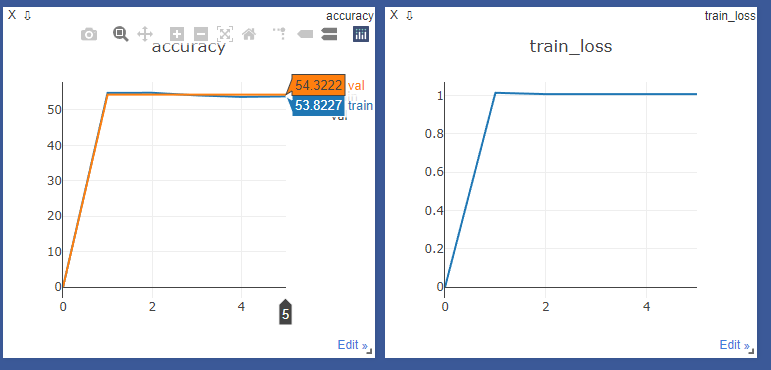

In [1]:
import torch, os
from torch.utils.data import DataLoader, SubsetRandomSampler, Subset
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from torch import optim  # 調整學習率更新策略
import visdom  # 訓練即時可視化工具
from tqdm import tqdm  # 訓練進度條
from torchinfo import summary  # 顯示model參數量、model大小
from sklearn.model_selection import KFold  # K_fold交叉驗證
from NIN_v1_model import NIN_v1  # 載入我的model
from NIN_v2_model import NIN_v2
from InceptionV3_model import Inception

## 1_設定參數

In [2]:
# 設定參數--------------------------------------------------------------------
batch_size = 32
img_size = 224  # 設定圖片resize大小
lr = 0.01  # 學習率
epoch = 30
use_GPU = True  # 是否使用GPU訓練
real_time_train_result = False  # 若不想開啟Visdom，就設為"False"
optim = 'SGD'  # 優化器: SGD, Adam
choose_model = 'Inception'  # 模型: NIN_v1, NIN_v2, Inception
choose_data_split, split_num = 'K_fold', 5  # 驗證方式: original(data=data), K_fold(data=data_kfold)

MODEL = 'best_model.pth'  # 保存model名稱
classes = {0: 'cloth_mask', 1: 'face_no_mask', 2:'mask_surgical'}  # 設定dataset classes類別

# 強迫固定初始權重，方便研究用
np.random.seed(0)
torch.manual_seed(0)

## 2.1_資料前處理-transform

In [3]:
# 資料前處理
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

transform_train = transforms.Compose([
    transforms.Resize((img_size,img_size)), # 強制224x224
    #transforms.RandomResizedCrop(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

transform_val = transforms.Compose([
    transforms.Resize((img_size,img_size)), #長=256 寬=等比例縮小
    #transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    normalize
])

## 2.2_資料前處理-資料分割方式
- **K-fold:**
    - 解釋: https://ithelp.ithome.com.tw/articles/10278851
    - 寫法教學: https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-pytorch.md

In [4]:
# 方法一: 資料夾先分好
if choose_data_split == 'original':
    train_data = datasets.ImageFolder('data/train/', transform=transform_train)
    trainloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)  # shuffle: 每次batch_size取不同dataset
    val_data = datasets.ImageFolder('data/val/', transform=transform_val)
    valloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    
    print("訓練張數有: ", len(trainloader.dataset))
    print("驗證張數有: ", len(valloader.dataset))
    print("在此batch_size下，trainloader跌帶次數: ", len(trainloader))
    print("在此batch_size下，valloader跌帶次數: ", len(valloader))
    
# 方法二: K_fold方式 (資料夾未先分train, val)
elif choose_data_split == 'K_fold':
    train_data = datasets.ImageFolder('data_kfold/', transform=transform_train)
    
    # 設定交叉驗證區分幾塊
    K_fold = KFold(n_splits = split_num, shuffle=True, random_state=42)
    
    # 方便觀察用，真正使用會在後面"迴圈主程式"，位置擺在for i in epoch的外層
    for K_fold_num, (train_idx, valid_idx) in enumerate(K_fold.split(train_data)):  # k_fold分割方式 -> (train, val)
        print(f'K_fold: {K_fold_num}')
        fack_train_sampler = SubsetRandomSampler(train_idx)  # 打亂id (1,2,3,4) -> (3,1,,4,2)
        fack_valid_sampler = SubsetRandomSampler(valid_idx)
        fack_trainloader = DataLoader(train_data, batch_size=batch_size, sampler=fack_train_sampler, shuffle=False)  # 有sampler就不會有shuffle
        fack_valloader = DataLoader(train_data, batch_size=batch_size, sampler=fack_valid_sampler, shuffle=False)

    print("\n訓練張數有: ", len(fack_train_sampler))  # !!注意:這裡不能用trainloader_datasets
    print("驗證張數有: ", len(fack_valid_sampler))
    print("在此batch_size下，trainloader跌帶次數: ", len(fack_trainloader))
    print("在此batch_size下，valloader跌帶次數: ", len(fack_valloader))
    

K_fold: 0
K_fold: 1
K_fold: 2
K_fold: 3
K_fold: 4

訓練張數有:  4026
驗證張數有:  1006
在此batch_size下，trainloader跌帶次數:  126
在此batch_size下，valloader跌帶次數:  32


## 3.1_查看model參數量

In [5]:
# 選擇查看模型
#choose_model = 'NIN_v1'  # 快速查看
if choose_model == 'NIN_v1':
    model = NIN_v1(num_classes=len(classes))
elif choose_model == 'NIN_v2':
    model = NIN_v2(num_classes=len(classes))
elif choose_model == 'Inception':
    model = Inception(pretrained=0, num_classes=len(classes))
model_parameter = summary(model, input_size=(batch_size, 3, img_size, img_size))  # 算出model parm
print("我選擇的模型: ", choose_model,"\n")
print(model_parameter)

我選擇的模型:  Inception 

Layer (type:depth-idx)                   Output Shape              Param #
Inception3                               [32, 3]                   --
├─BasicConv2d: 1-1                       [32, 32, 111, 111]        --
│    └─Conv2d: 2-1                       [32, 32, 111, 111]        864
│    └─BatchNorm2d: 2-2                  [32, 32, 111, 111]        64
├─BasicConv2d: 1-2                       [32, 32, 109, 109]        --
│    └─Conv2d: 2-3                       [32, 32, 109, 109]        9,216
│    └─BatchNorm2d: 2-4                  [32, 32, 109, 109]        64
├─BasicConv2d: 1-3                       [32, 64, 109, 109]        --
│    └─Conv2d: 2-5                       [32, 64, 109, 109]        18,432
│    └─BatchNorm2d: 2-6                  [32, 64, 109, 109]        128
├─BasicConv2d: 1-4                       [32, 80, 54, 54]          --
│    └─Conv2d: 2-7                       [32, 80, 54, 54]          5,120
│    └─BatchNorm2d: 2-8                  [32, 80, 54

## 3.2_訓練模型(train,val)

In [6]:
# train_function_v1
def train(trainloader, model, use_GPU, epoch, loss_func, optimizer):
    model.train()
    correct, total = 0, 0
    train_acc = 0
    acc_sum, loss_sum = 0, 0
    i = 0
    
    #訓練進度條
    trainloader_tqdm = tqdm(trainloader)
    
    optimizer.zero_grad()
    for batch_idx, (data, target) in enumerate(trainloader_tqdm):
        if use_GPU == True:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)

        # calculate accuracy
        correct += (torch.max(output, 1)[1].view(target.size()).data == target.data).sum()
        total += trainloader.batch_size
        train_acc = 100. * correct / total
        acc_sum += train_acc
        i += 1

        loss = loss_func(output, target)
        
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()
        
        # 顯示方法1: 每跑100批batch_size查看一次
        """
        if choose_data_split == 'original':
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.3f}\tTraining Accuracy: {:.3f}%'.format(
                    epoch, batch_idx * len(data), len(trainloader.dataset),
                    100. * batch_idx / len(trainloader), loss.item(), train_acc))
                
        elif choose_data_split == 'K_fold':
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.3f}\tTraining Accuracy: {:.3f}%'.format(
                    epoch, batch_idx * len(data), len(train_sampler),
                    100. * batch_idx / len(trainloader), loss.item(), train_acc))
        """
        # 顯示方法2: tqdm訓練進度條顯示
        if choose_data_split == 'original':
            trainloader_tqdm.desc = f'Train Epoch: {epoch} [{batch_idx*len(data)}/{len(trainloader.dataset)} ({100. * batch_idx / len(trainloader):.0f}%)]\tLoss: {loss.item():.3f}\tTraining Accuracy: {train_acc:.3f}%'  # 進度條工具
        elif choose_data_split == 'K_fold':
            trainloader_tqdm.desc = f'Train Epoch: {epoch} [{batch_idx*len(data)}/{len(train_sampler)} ({100. * batch_idx / len(trainloader):.0f}%)]\tLoss: {loss.item():.3f}\tTraining Accuracy: {train_acc:.3f}%'  # 進度條工具
    
    # 每回合eopch的train loss, accuracy
    acc_avg = acc_sum / i
    loss_avg = loss_sum / len(trainloader)

    print('Train Epoch: {}\tAverage Loss: {:.3f}\tAverage Accuracy: {:.3f}%'.format(epoch, loss_avg, acc_avg))
    
    return acc_avg, loss_avg

In [7]:
# val_function
def val(valloader, model, use_GPU, loss_func, epoch):
    model.eval()
    val_loss = 0
    val_correct_num = 0
    with torch.no_grad():
        for i, (data, target) in enumerate(valloader):
            if use_GPU == True:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)
            output = model(data)
            
            # 算acc方法1:
            val_loss += loss_func(output, target).item()  # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
            val_correct_num += pred.eq(target.data.view_as(pred)).cpu().sum()
            
            # 算acc方法2:
            #_, idx = torch.max(output.data, dim=1)
            #val_correct_num += torch.sum(idx == target)

        val_loss /= len(valloader)

        if choose_data_split == 'original':
            val_correct_rate = 100. * val_correct_num / len(valloader.dataset)
            result = 'Val set -> Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)'.format(
                val_loss, val_correct_num, len(valloader.dataset), val_correct_rate)

        elif choose_data_split == 'K_fold':
            val_correct_rate = 100. * val_correct_num / len(valid_sampler)  # valloader.dataset -> valid_sampler
            result = 'Val set -> Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)'.format(
                val_loss, val_correct_num, len(valid_sampler), val_correct_rate)  
        print(result)
    return val_correct_rate, val_loss

## 3.3_model初始化權重

In [8]:
# 初始化權重
# 在K_fold期間，它將用於重置模型的參數。這樣我們能確保模型使用隨機初始化（偽）的權重進行訓練，避免權重洩漏。
def reset_weights(m):
    # Try resetting model weights to avoid weight leakage.
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            #print(f'Reset trainable parameters of layer = {layer}')  # 顯示初始化了多少layer
            layer.reset_parameters()

## 4_運行主程式

In [9]:
# main---------------------------------------------
# 保存loss歷史數據，plt看圖用
train_loss_list = np.zeros(epoch+1)
train_acc_list = np.zeros(epoch+1)
val_acc_list = np.zeros(epoch+1)
val_loss_list = np.zeros(epoch+1)

# 在訓練的過程中會根據驗證集的最佳準確率保存模型
best_val_correct_rate = 0.0

#訓練可視化-初始化窗口----------------------------------------------------
if real_time_train_result == True:
    vis = visdom.Visdom(server='http://localhost', port=8097, env='main')
    vis.line([[0., 0.]], [0], win='accuracy', opts=dict(title='accuracy', legend = ['train','val']))   # [y軸1,y軸2][x軸] legend=標籤
    vis.line([0.], [0], win='train_loss', opts=dict(title='train_loss'))   # [y軸][x軸] 
#------------------------------------------------------------------------

# 判斷資料分割模式
if choose_data_split == 'K_fold':
    K_fold_acc = {}  # 保存history
    for K_fold_num, (train_idx, valid_idx) in enumerate(K_fold.split(train_data)):  # k_fold分割方式
        # 選擇訓練模型
        if choose_model == 'NIN_v1':
            net = NIN_v1(num_classes=len(classes))
        elif choose_model == 'NIN_v2':
            net = NIN_v2(num_classes=len(classes))
        elif choose_model == 'Inception':
            net = Inception(pretrained=0, num_classes=len(classes))
        # 使用GPU訓練
        net.cuda()

        # 初始化模型權重
        net.apply(reset_weights)
        # 初始化優化器
        if optim == 'SGD':
            optimizer = torch.optim.SGD(params = net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
        elif optim == 'Adam':
            optimizer = torch.optim.Adam(params = net.parameters(), lr=lr)
            
        # K_fold_acc = 最佳epoch val_acc
        best_val_acc = 0.0
            
        # 設定loss function
        loss_func = torch.nn.CrossEntropyLoss() 
        # 設定學習策略
        # patience:幾次沒改善時，降低1次學習率; factor:更新時相乘的衰減係數; mode:min=loss, acc=max
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.1, patience=2, min_lr=0.00001)  
        
        
        print('--------------------------------')
        print(f'K_fold: {K_fold_num}')
        train_sampler = SubsetRandomSampler(train_idx)  # 打亂訓練id順序 (1,2,3,4) -> (3,1,4,2)
        valid_sampler = SubsetRandomSampler(valid_idx)
        trainloader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, shuffle=False)  # 有sampler就不會有shuffle
        valloader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, shuffle=False)

        # 開始epoch訓練
        for i in range (1, epoch + 1):
            acc_avg, loss_avg = train(trainloader, net, use_GPU, i, loss_func, optimizer)
            val_acc, val_loss = val(valloader, net, use_GPU, loss_func, i)

            train_loss_list[i] = loss_avg  # 保存train_loss history
            train_acc_list[i] = acc_avg  # 保存train_acc history
            val_acc_list[i] = val_acc  # 保存val_loss history
            val_loss_list[i] = val_loss  # 保存val_acc history
            
            if best_val_acc < val_acc:
                best_val_acc = val_acc

            #即時可視化訓練過程(accuracy, loss)-------------------------------------------------
            if real_time_train_result == True:
                vis.line([[acc_avg.item(), val_acc.item()]], [i], win='accuracy', update='append')  # 添加訊息到初始化的窗口
                vis.line([loss_avg], [i], win='train_loss', update='append')  # 添加訊息到初始化的窗口
            #----------------------------------------------------------------------------------
            
            # 保存最佳模型
            if val_acc > best_val_correct_rate:
                best_val_correct_rate = val_acc
                # 每回合結束，保存最佳模型
                #torch.save(net.state_dict(), MODEL)  # 只保存訓練好權重
                torch.save(net, MODEL)  # 保存整個模型
                
            # 根據驗證集準確率更新學習率
            lr_scheduler.step(val_loss)  # 連結到上面"lr_scheduler" 若監控的是loss，上面要改為min
            
        K_fold_acc[K_fold_num] = best_val_acc  # K_fold_acc = 所有epoch中最佳的val_Acc
        
    print('\n--------------------------------')
    print(f'{K_fold_num+1}次 K-fold 交叉驗證結果:')
    sum_acc = 0.0
    for num, value in K_fold_acc.items():
        print(f'K_fold {num} -> {value:.3f} %')
        sum_acc += value
    print(f'K_fold Average Accuracy: {sum_acc/len(K_fold_acc.items()):.3f} %')
    print('--------------------------------\n')
    
elif choose_data_split == 'original':
    # 選擇訓練模型
    if choose_model == 'NIN_v1':
        net = NIN_v1(num_classes=len(classes))
    elif choose_model == 'NIN_v2':
        net = NIN_v2(num_classes=len(classes))
    elif choose_model == 'Inception':
        net = Inception(pretrained=0, num_classes=len(classes))
    # 使用GPU訓練
    net.cuda()
    
    # 初始化模型權重
    net.apply(reset_weights)
    # 初始化優化器
    if optim == 'SGD':
        optimizer = torch.optim.SGD(params = net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    elif optim == 'Adam':
        optimizer = torch.optim.Adam(params = net.parameters(), lr=lr)
        
    # 設定loss function
    loss_func = torch.nn.CrossEntropyLoss() 
    # 設定學習策略
    # patience:幾次沒改善時，降低1次學習率; factor:更新時相乘的衰減係數; mode:min=loss, acc=max
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='max', factor=0.1, patience=4, min_lr=0.00001)  

    # 開始epoch訓練
    for i in range (1, epoch + 1):
        acc_avg, loss_avg = train(trainloader, net, use_GPU, i, loss_func, optimizer)
        val_acc, val_loss = val(valloader, net, use_GPU, loss_func, i)

        train_loss_list[i] = loss_avg  # 保存train_loss history
        train_acc_list[i] = acc_avg  # 保存train_acc history
        val_acc_list[i] = val_acc  # 保存val_loss history
        val_loss_list[i] = val_loss  # 保存val_acc history

        #即時可視化訓練過程(accuracy, loss)-------------------------------------------------
        if real_time_train_result == True:
            vis.line([[acc_avg.item(), val_acc.item()]], [i], win='accuracy', update='append')  # 添加訊息到初始化的窗口
            vis.line([loss_avg], [i], win='train_loss', update='append')  # 添加訊息到初始化的窗口
        #----------------------------------------------------------------------------------

        # 保存最佳模型
        if val_acc > best_val_correct_rate:
            best_val_correct_rate = val_acc
            # 每回合結束，保存最佳模型
            #torch.save(net.state_dict(), MODEL)  # 只保存訓練好權重
            torch.save(net, MODEL)  # 保存整個模型
            
        # 根據驗證集準確率更新學習率
        lr_scheduler.step(val_acc)  # 連結到上面"lr_scheduler" 若監控的是loss，上面要改為min

print('train finished.')
print("\a")  # 訓練完，提示音提醒我~

--------------------------------
K_fold: 0


Train Epoch: 1 [3125/4025 (99%)]	Loss: 1.347	Training Accuracy: 53.745%: 100%|███████| 126/126 [00:58<00:00,  2.16it/s]


Train Epoch: 1	Average Loss: 1.325	Average Accuracy: 53.848%
Val set -> Average loss: 2.2335, Accuracy: 510/1007 (50.645%)


Train Epoch: 2 [3125/4025 (99%)]	Loss: 1.801	Training Accuracy: 53.919%: 100%|███████| 126/126 [00:57<00:00,  2.21it/s]


Train Epoch: 2	Average Loss: 1.233	Average Accuracy: 53.800%
Val set -> Average loss: 1.5600, Accuracy: 507/1007 (50.348%)


Train Epoch: 3 [3125/4025 (99%)]	Loss: 1.089	Training Accuracy: 54.588%: 100%|███████| 126/126 [00:57<00:00,  2.19it/s]


Train Epoch: 3	Average Loss: 1.141	Average Accuracy: 54.157%
Val set -> Average loss: 1.0615, Accuracy: 456/1007 (45.283%)


Train Epoch: 4 [3125/4025 (99%)]	Loss: 0.703	Training Accuracy: 56.597%: 100%|███████| 126/126 [00:55<00:00,  2.26it/s]


Train Epoch: 4	Average Loss: 1.056	Average Accuracy: 56.557%
Val set -> Average loss: 1.4554, Accuracy: 546/1007 (54.220%)


Train Epoch: 5 [3125/4025 (99%)]	Loss: 0.752	Training Accuracy: 57.416%: 100%|███████| 126/126 [00:58<00:00,  2.16it/s]


Train Epoch: 5	Average Loss: 1.048	Average Accuracy: 57.728%
Val set -> Average loss: 1.3607, Accuracy: 522/1007 (51.837%)


Train Epoch: 6 [3125/4025 (99%)]	Loss: 0.787	Training Accuracy: 58.730%: 100%|███████| 126/126 [00:57<00:00,  2.18it/s]


Train Epoch: 6	Average Loss: 0.992	Average Accuracy: 58.391%
Val set -> Average loss: 0.9934, Accuracy: 563/1007 (55.909%)


Train Epoch: 7 [3125/4025 (99%)]	Loss: 0.722	Training Accuracy: 60.243%: 100%|███████| 126/126 [00:58<00:00,  2.14it/s]


Train Epoch: 7	Average Loss: 0.972	Average Accuracy: 60.154%
Val set -> Average loss: 0.9863, Accuracy: 574/1007 (57.001%)


Train Epoch: 8 [3125/4025 (99%)]	Loss: 0.916	Training Accuracy: 61.086%: 100%|███████| 126/126 [00:56<00:00,  2.22it/s]


Train Epoch: 8	Average Loss: 0.946	Average Accuracy: 61.745%
Val set -> Average loss: 1.0283, Accuracy: 599/1007 (59.484%)


Train Epoch: 9 [3125/4025 (99%)]	Loss: 0.646	Training Accuracy: 61.682%: 100%|███████| 126/126 [00:56<00:00,  2.22it/s]


Train Epoch: 9	Average Loss: 0.942	Average Accuracy: 62.238%
Val set -> Average loss: 1.5769, Accuracy: 580/1007 (57.597%)


Train Epoch: 10 [3125/4025 (99%)]	Loss: 0.820	Training Accuracy: 62.054%: 100%|██████| 126/126 [00:55<00:00,  2.27it/s]


Train Epoch: 10	Average Loss: 0.928	Average Accuracy: 62.157%
Val set -> Average loss: 0.9572, Accuracy: 589/1007 (58.491%)


Train Epoch: 11 [3125/4025 (99%)]	Loss: 0.829	Training Accuracy: 62.847%: 100%|██████| 126/126 [00:56<00:00,  2.24it/s]


Train Epoch: 11	Average Loss: 0.889	Average Accuracy: 62.969%
Val set -> Average loss: 0.9416, Accuracy: 628/1007 (62.363%)


Train Epoch: 12 [3125/4025 (99%)]	Loss: 0.928	Training Accuracy: 64.633%: 100%|██████| 126/126 [00:57<00:00,  2.21it/s]


Train Epoch: 12	Average Loss: 0.866	Average Accuracy: 63.956%
Val set -> Average loss: 1.6114, Accuracy: 607/1007 (60.278%)


Train Epoch: 13 [3125/4025 (99%)]	Loss: 0.867	Training Accuracy: 64.137%: 100%|██████| 126/126 [00:57<00:00,  2.20it/s]


Train Epoch: 13	Average Loss: 0.886	Average Accuracy: 64.027%
Val set -> Average loss: 1.0170, Accuracy: 616/1007 (61.172%)


Train Epoch: 14 [3125/4025 (99%)]	Loss: 0.682	Training Accuracy: 66.344%: 100%|██████| 126/126 [00:58<00:00,  2.16it/s]


Train Epoch: 14	Average Loss: 0.839	Average Accuracy: 65.997%
Val set -> Average loss: 0.9588, Accuracy: 632/1007 (62.761%)


Train Epoch: 15 [3125/4025 (99%)]	Loss: 0.754	Training Accuracy: 68.552%: 100%|██████| 126/126 [00:57<00:00,  2.20it/s]


Train Epoch: 15	Average Loss: 0.775	Average Accuracy: 68.120%
Val set -> Average loss: 0.9413, Accuracy: 674/1007 (66.931%)


Train Epoch: 16 [3125/4025 (99%)]	Loss: 0.879	Training Accuracy: 70.809%: 100%|██████| 126/126 [00:58<00:00,  2.17it/s]


Train Epoch: 16	Average Loss: 0.725	Average Accuracy: 70.910%
Val set -> Average loss: 0.8476, Accuracy: 675/1007 (67.031%)


Train Epoch: 17 [3125/4025 (99%)]	Loss: 1.059	Training Accuracy: 70.660%: 100%|██████| 126/126 [00:57<00:00,  2.20it/s]


Train Epoch: 17	Average Loss: 0.726	Average Accuracy: 70.444%
Val set -> Average loss: 1.1069, Accuracy: 668/1007 (66.336%)


Train Epoch: 18 [3125/4025 (99%)]	Loss: 1.020	Training Accuracy: 71.577%: 100%|██████| 126/126 [00:58<00:00,  2.16it/s]


Train Epoch: 18	Average Loss: 0.707	Average Accuracy: 72.300%
Val set -> Average loss: 0.9264, Accuracy: 660/1007 (65.541%)


Train Epoch: 19 [3125/4025 (99%)]	Loss: 0.750	Training Accuracy: 71.925%: 100%|██████| 126/126 [00:56<00:00,  2.23it/s]


Train Epoch: 19	Average Loss: 0.690	Average Accuracy: 72.406%
Val set -> Average loss: 0.8916, Accuracy: 685/1007 (68.024%)


Train Epoch: 20 [3125/4025 (99%)]	Loss: 0.595	Training Accuracy: 73.041%: 100%|██████| 126/126 [00:58<00:00,  2.16it/s]


Train Epoch: 20	Average Loss: 0.658	Average Accuracy: 72.493%
Val set -> Average loss: 1.0101, Accuracy: 686/1007 (68.123%)


Train Epoch: 21 [3125/4025 (99%)]	Loss: 0.557	Training Accuracy: 73.189%: 100%|██████| 126/126 [00:56<00:00,  2.23it/s]


Train Epoch: 21	Average Loss: 0.654	Average Accuracy: 73.464%
Val set -> Average loss: 0.9361, Accuracy: 674/1007 (66.931%)


Train Epoch: 22 [3125/4025 (99%)]	Loss: 0.737	Training Accuracy: 73.586%: 100%|██████| 126/126 [00:57<00:00,  2.20it/s]


Train Epoch: 22	Average Loss: 0.661	Average Accuracy: 73.246%
Val set -> Average loss: 0.8508, Accuracy: 677/1007 (67.229%)


Train Epoch: 23 [3125/4025 (99%)]	Loss: 0.438	Training Accuracy: 73.661%: 100%|██████| 126/126 [00:59<00:00,  2.13it/s]


Train Epoch: 23	Average Loss: 0.656	Average Accuracy: 74.048%
Val set -> Average loss: 0.9858, Accuracy: 674/1007 (66.931%)


Train Epoch: 24 [3125/4025 (99%)]	Loss: 0.473	Training Accuracy: 73.859%: 100%|██████| 126/126 [00:57<00:00,  2.20it/s]


Train Epoch: 24	Average Loss: 0.650	Average Accuracy: 72.795%
Val set -> Average loss: 0.9058, Accuracy: 675/1007 (67.031%)


Train Epoch: 25 [3125/4025 (99%)]	Loss: 0.551	Training Accuracy: 73.562%: 100%|██████| 126/126 [00:57<00:00,  2.19it/s]


Train Epoch: 25	Average Loss: 0.647	Average Accuracy: 73.570%
Val set -> Average loss: 0.9326, Accuracy: 682/1007 (67.726%)


Train Epoch: 26 [3125/4025 (99%)]	Loss: 0.570	Training Accuracy: 73.586%: 100%|██████| 126/126 [00:56<00:00,  2.22it/s]


Train Epoch: 26	Average Loss: 0.651	Average Accuracy: 73.754%
Val set -> Average loss: 0.8716, Accuracy: 674/1007 (66.931%)


Train Epoch: 27 [3125/4025 (99%)]	Loss: 1.170	Training Accuracy: 73.760%: 100%|██████| 126/126 [00:56<00:00,  2.23it/s]


Train Epoch: 27	Average Loss: 0.645	Average Accuracy: 74.142%
Val set -> Average loss: 0.8627, Accuracy: 686/1007 (68.123%)


Train Epoch: 28 [3125/4025 (99%)]	Loss: 0.504	Training Accuracy: 74.033%: 100%|██████| 126/126 [00:56<00:00,  2.22it/s]


Train Epoch: 28	Average Loss: 0.642	Average Accuracy: 73.781%
Val set -> Average loss: 0.9241, Accuracy: 687/1007 (68.222%)


Train Epoch: 29 [3125/4025 (99%)]	Loss: 0.849	Training Accuracy: 73.413%: 100%|██████| 126/126 [00:57<00:00,  2.18it/s]


Train Epoch: 29	Average Loss: 0.646	Average Accuracy: 73.599%
Val set -> Average loss: 1.0074, Accuracy: 670/1007 (66.534%)


Train Epoch: 30 [3125/4025 (99%)]	Loss: 0.842	Training Accuracy: 73.710%: 100%|██████| 126/126 [00:59<00:00,  2.11it/s]


Train Epoch: 30	Average Loss: 0.649	Average Accuracy: 74.857%
Val set -> Average loss: 1.0607, Accuracy: 676/1007 (67.130%)
--------------------------------
K_fold: 1


Train Epoch: 1 [3125/4025 (99%)]	Loss: 0.879	Training Accuracy: 51.116%: 100%|███████| 126/126 [00:57<00:00,  2.20it/s]


Train Epoch: 1	Average Loss: 1.425	Average Accuracy: 49.749%
Val set -> Average loss: 6.3065, Accuracy: 518/1007 (51.440%)


Train Epoch: 2 [3125/4025 (99%)]	Loss: 1.025	Training Accuracy: 53.472%: 100%|███████| 126/126 [00:55<00:00,  2.28it/s]


Train Epoch: 2	Average Loss: 1.243	Average Accuracy: 54.860%
Val set -> Average loss: 1.0732, Accuracy: 541/1007 (53.724%)


Train Epoch: 3 [3125/4025 (99%)]	Loss: 0.940	Training Accuracy: 54.390%: 100%|███████| 126/126 [00:58<00:00,  2.15it/s]


Train Epoch: 3	Average Loss: 1.095	Average Accuracy: 52.246%
Val set -> Average loss: 0.9817, Accuracy: 553/1007 (54.916%)


Train Epoch: 4 [3125/4025 (99%)]	Loss: 1.044	Training Accuracy: 56.300%: 100%|███████| 126/126 [00:56<00:00,  2.24it/s]


Train Epoch: 4	Average Loss: 1.051	Average Accuracy: 55.473%
Val set -> Average loss: 1.0092, Accuracy: 601/1007 (59.682%)


Train Epoch: 5 [3125/4025 (99%)]	Loss: 1.062	Training Accuracy: 57.937%: 100%|███████| 126/126 [00:55<00:00,  2.26it/s]


Train Epoch: 5	Average Loss: 1.019	Average Accuracy: 55.810%
Val set -> Average loss: 1.0506, Accuracy: 596/1007 (59.186%)


Train Epoch: 6 [3125/4025 (99%)]	Loss: 0.957	Training Accuracy: 59.573%: 100%|███████| 126/126 [00:55<00:00,  2.25it/s]


Train Epoch: 6	Average Loss: 0.984	Average Accuracy: 58.973%
Val set -> Average loss: 0.9854, Accuracy: 632/1007 (62.761%)


Train Epoch: 7 [3125/4025 (99%)]	Loss: 0.825	Training Accuracy: 62.054%: 100%|███████| 126/126 [00:55<00:00,  2.25it/s]


Train Epoch: 7	Average Loss: 0.909	Average Accuracy: 60.582%
Val set -> Average loss: 0.8736, Accuracy: 655/1007 (65.045%)


Train Epoch: 8 [3125/4025 (99%)]	Loss: 1.185	Training Accuracy: 62.996%: 100%|███████| 126/126 [00:55<00:00,  2.25it/s]


Train Epoch: 8	Average Loss: 0.886	Average Accuracy: 62.712%
Val set -> Average loss: 0.8325, Accuracy: 658/1007 (65.343%)


Train Epoch: 9 [3125/4025 (99%)]	Loss: 0.669	Training Accuracy: 63.467%: 100%|███████| 126/126 [00:56<00:00,  2.24it/s]


Train Epoch: 9	Average Loss: 0.877	Average Accuracy: 63.708%
Val set -> Average loss: 0.9401, Accuracy: 640/1007 (63.555%)


Train Epoch: 10 [3125/4025 (99%)]	Loss: 0.764	Training Accuracy: 63.095%: 100%|██████| 126/126 [00:56<00:00,  2.24it/s]


Train Epoch: 10	Average Loss: 0.884	Average Accuracy: 62.922%
Val set -> Average loss: 0.8598, Accuracy: 659/1007 (65.442%)


Train Epoch: 11 [3125/4025 (99%)]	Loss: 0.840	Training Accuracy: 64.286%: 100%|██████| 126/126 [00:55<00:00,  2.26it/s]


Train Epoch: 11	Average Loss: 0.865	Average Accuracy: 65.193%
Val set -> Average loss: 0.8274, Accuracy: 656/1007 (65.144%)


Train Epoch: 12 [3125/4025 (99%)]	Loss: 0.945	Training Accuracy: 64.559%: 100%|██████| 126/126 [00:55<00:00,  2.26it/s]


Train Epoch: 12	Average Loss: 0.853	Average Accuracy: 65.938%
Val set -> Average loss: 0.8446, Accuracy: 657/1007 (65.243%)


Train Epoch: 13 [3125/4025 (99%)]	Loss: 0.738	Training Accuracy: 65.699%: 100%|██████| 126/126 [00:56<00:00,  2.24it/s]


Train Epoch: 13	Average Loss: 0.813	Average Accuracy: 65.547%
Val set -> Average loss: 0.8585, Accuracy: 641/1007 (63.654%)


Train Epoch: 14 [3125/4025 (99%)]	Loss: 0.874	Training Accuracy: 65.451%: 100%|██████| 126/126 [00:55<00:00,  2.25it/s]


Train Epoch: 14	Average Loss: 0.817	Average Accuracy: 65.254%
Val set -> Average loss: 0.8353, Accuracy: 660/1007 (65.541%)


Train Epoch: 15 [3125/4025 (99%)]	Loss: 0.879	Training Accuracy: 67.336%: 100%|██████| 126/126 [00:56<00:00,  2.24it/s]


Train Epoch: 15	Average Loss: 0.805	Average Accuracy: 67.873%
Val set -> Average loss: 0.7958, Accuracy: 657/1007 (65.243%)


Train Epoch: 16 [3125/4025 (99%)]	Loss: 1.231	Training Accuracy: 67.758%: 100%|██████| 126/126 [00:55<00:00,  2.26it/s]


Train Epoch: 16	Average Loss: 0.785	Average Accuracy: 67.727%
Val set -> Average loss: 0.7882, Accuracy: 673/1007 (66.832%)


Train Epoch: 17 [3125/4025 (99%)]	Loss: 0.794	Training Accuracy: 68.229%: 100%|██████| 126/126 [00:55<00:00,  2.26it/s]


Train Epoch: 17	Average Loss: 0.768	Average Accuracy: 68.592%
Val set -> Average loss: 0.8101, Accuracy: 673/1007 (66.832%)


Train Epoch: 18 [3125/4025 (99%)]	Loss: 0.893	Training Accuracy: 68.552%: 100%|██████| 126/126 [00:56<00:00,  2.25it/s]


Train Epoch: 18	Average Loss: 0.765	Average Accuracy: 67.927%
Val set -> Average loss: 0.7939, Accuracy: 681/1007 (67.627%)


Train Epoch: 19 [3125/4025 (99%)]	Loss: 0.753	Training Accuracy: 68.229%: 100%|██████| 126/126 [00:59<00:00,  2.13it/s]


Train Epoch: 19	Average Loss: 0.770	Average Accuracy: 68.775%
Val set -> Average loss: 0.7949, Accuracy: 674/1007 (66.931%)


Train Epoch: 20 [3125/4025 (99%)]	Loss: 0.658	Training Accuracy: 69.221%: 100%|██████| 126/126 [00:56<00:00,  2.23it/s]


Train Epoch: 20	Average Loss: 0.749	Average Accuracy: 69.287%
Val set -> Average loss: 0.7952, Accuracy: 674/1007 (66.931%)


Train Epoch: 21 [3125/4025 (99%)]	Loss: 0.864	Training Accuracy: 68.452%: 100%|██████| 126/126 [00:56<00:00,  2.25it/s]


Train Epoch: 21	Average Loss: 0.754	Average Accuracy: 69.743%
Val set -> Average loss: 0.7993, Accuracy: 689/1007 (68.421%)


Train Epoch: 22 [3125/4025 (99%)]	Loss: 1.090	Training Accuracy: 69.593%: 100%|██████| 126/126 [00:57<00:00,  2.19it/s]


Train Epoch: 22	Average Loss: 0.753	Average Accuracy: 68.880%
Val set -> Average loss: 0.8273, Accuracy: 673/1007 (66.832%)


Train Epoch: 23 [3125/4025 (99%)]	Loss: 0.785	Training Accuracy: 69.097%: 100%|██████| 126/126 [00:56<00:00,  2.23it/s]


Train Epoch: 23	Average Loss: 0.760	Average Accuracy: 69.443%
Val set -> Average loss: 0.8052, Accuracy: 683/1007 (67.825%)


Train Epoch: 24 [3125/4025 (99%)]	Loss: 0.612	Training Accuracy: 69.320%: 100%|██████| 126/126 [00:56<00:00,  2.23it/s]


Train Epoch: 24	Average Loss: 0.749	Average Accuracy: 69.059%
Val set -> Average loss: 0.8258, Accuracy: 677/1007 (67.229%)


Train Epoch: 25 [3125/4025 (99%)]	Loss: 1.087	Training Accuracy: 68.676%: 100%|██████| 126/126 [00:55<00:00,  2.25it/s]


Train Epoch: 25	Average Loss: 0.747	Average Accuracy: 69.403%
Val set -> Average loss: 0.7918, Accuracy: 681/1007 (67.627%)


Train Epoch: 26 [3125/4025 (99%)]	Loss: 0.767	Training Accuracy: 68.973%: 100%|██████| 126/126 [00:57<00:00,  2.19it/s]


Train Epoch: 26	Average Loss: 0.744	Average Accuracy: 69.938%
Val set -> Average loss: 0.8156, Accuracy: 681/1007 (67.627%)


Train Epoch: 27 [3125/4025 (99%)]	Loss: 0.676	Training Accuracy: 69.742%: 100%|██████| 126/126 [00:55<00:00,  2.28it/s]


Train Epoch: 27	Average Loss: 0.740	Average Accuracy: 69.658%
Val set -> Average loss: 0.8237, Accuracy: 675/1007 (67.031%)


Train Epoch: 28 [3125/4025 (99%)]	Loss: 0.874	Training Accuracy: 68.601%: 100%|██████| 126/126 [00:57<00:00,  2.18it/s]


Train Epoch: 28	Average Loss: 0.760	Average Accuracy: 67.906%
Val set -> Average loss: 0.8149, Accuracy: 680/1007 (67.527%)


Train Epoch: 29 [3125/4025 (99%)]	Loss: 0.666	Training Accuracy: 69.395%: 100%|██████| 126/126 [00:56<00:00,  2.23it/s]


Train Epoch: 29	Average Loss: 0.756	Average Accuracy: 70.044%
Val set -> Average loss: 0.8078, Accuracy: 678/1007 (67.329%)


Train Epoch: 30 [3125/4025 (99%)]	Loss: 0.828	Training Accuracy: 69.221%: 100%|██████| 126/126 [00:54<00:00,  2.30it/s]


Train Epoch: 30	Average Loss: 0.757	Average Accuracy: 69.541%
Val set -> Average loss: 0.8268, Accuracy: 668/1007 (66.336%)
--------------------------------
K_fold: 2


Train Epoch: 1 [3250/4026 (99%)]	Loss: 1.073	Training Accuracy: 50.670%: 100%|███████| 126/126 [00:56<00:00,  2.22it/s]


Train Epoch: 1	Average Loss: 1.461	Average Accuracy: 49.597%
Val set -> Average loss: 1.1208, Accuracy: 417/1006 (41.451%)


Train Epoch: 2 [3250/4026 (99%)]	Loss: 1.521	Training Accuracy: 53.100%: 100%|███████| 126/126 [00:59<00:00,  2.11it/s]


Train Epoch: 2	Average Loss: 1.299	Average Accuracy: 53.820%
Val set -> Average loss: 1.9871, Accuracy: 553/1006 (54.970%)


Train Epoch: 3 [3250/4026 (99%)]	Loss: 1.008	Training Accuracy: 53.299%: 100%|███████| 126/126 [00:56<00:00,  2.24it/s]


Train Epoch: 3	Average Loss: 1.122	Average Accuracy: 52.394%
Val set -> Average loss: 0.9522, Accuracy: 563/1006 (55.964%)


Train Epoch: 4 [3250/4026 (99%)]	Loss: 0.908	Training Accuracy: 54.464%: 100%|███████| 126/126 [00:56<00:00,  2.25it/s]


Train Epoch: 4	Average Loss: 1.100	Average Accuracy: 54.488%
Val set -> Average loss: 1.2820, Accuracy: 581/1006 (57.753%)


Train Epoch: 5 [3250/4026 (99%)]	Loss: 1.389	Training Accuracy: 57.019%: 100%|███████| 126/126 [00:56<00:00,  2.25it/s]


Train Epoch: 5	Average Loss: 1.032	Average Accuracy: 56.800%
Val set -> Average loss: 0.9311, Accuracy: 605/1006 (60.139%)


Train Epoch: 6 [3250/4026 (99%)]	Loss: 1.065	Training Accuracy: 57.168%: 100%|███████| 126/126 [00:56<00:00,  2.25it/s]


Train Epoch: 6	Average Loss: 1.030	Average Accuracy: 57.044%
Val set -> Average loss: 0.9656, Accuracy: 608/1006 (60.437%)


Train Epoch: 7 [3250/4026 (99%)]	Loss: 1.071	Training Accuracy: 59.549%: 100%|███████| 126/126 [00:57<00:00,  2.21it/s]


Train Epoch: 7	Average Loss: 0.989	Average Accuracy: 59.826%
Val set -> Average loss: 0.9127, Accuracy: 623/1006 (61.928%)


Train Epoch: 8 [3250/4026 (99%)]	Loss: 0.775	Training Accuracy: 61.409%: 100%|███████| 126/126 [00:56<00:00,  2.23it/s]


Train Epoch: 8	Average Loss: 0.943	Average Accuracy: 60.550%
Val set -> Average loss: 1.0483, Accuracy: 644/1006 (64.016%)


Train Epoch: 9 [3250/4026 (99%)]	Loss: 0.706	Training Accuracy: 61.136%: 100%|███████| 126/126 [00:58<00:00,  2.17it/s]


Train Epoch: 9	Average Loss: 0.925	Average Accuracy: 61.340%
Val set -> Average loss: 1.0319, Accuracy: 590/1006 (58.648%)


Train Epoch: 10 [3250/4026 (99%)]	Loss: 0.902	Training Accuracy: 58.532%: 100%|██████| 126/126 [00:58<00:00,  2.16it/s]


Train Epoch: 10	Average Loss: 0.989	Average Accuracy: 60.146%
Val set -> Average loss: 1.2069, Accuracy: 575/1006 (57.157%)


Train Epoch: 11 [3250/4026 (99%)]	Loss: 0.669	Training Accuracy: 61.210%: 100%|██████| 126/126 [00:56<00:00,  2.23it/s]


Train Epoch: 11	Average Loss: 0.916	Average Accuracy: 60.090%
Val set -> Average loss: 0.8801, Accuracy: 626/1006 (62.227%)


Train Epoch: 12 [3250/4026 (99%)]	Loss: 0.885	Training Accuracy: 61.830%: 100%|██████| 126/126 [00:56<00:00,  2.23it/s]


Train Epoch: 12	Average Loss: 0.908	Average Accuracy: 62.352%
Val set -> Average loss: 0.9536, Accuracy: 632/1006 (62.823%)


Train Epoch: 13 [3250/4026 (99%)]	Loss: 1.116	Training Accuracy: 62.004%: 100%|██████| 126/126 [00:56<00:00,  2.23it/s]


Train Epoch: 13	Average Loss: 0.885	Average Accuracy: 61.252%
Val set -> Average loss: 0.8676, Accuracy: 647/1006 (64.314%)


Train Epoch: 14 [3250/4026 (99%)]	Loss: 0.972	Training Accuracy: 63.368%: 100%|██████| 126/126 [00:56<00:00,  2.24it/s]


Train Epoch: 14	Average Loss: 0.874	Average Accuracy: 63.215%
Val set -> Average loss: 0.8766, Accuracy: 644/1006 (64.016%)


Train Epoch: 15 [3250/4026 (99%)]	Loss: 1.094	Training Accuracy: 64.534%: 100%|██████| 126/126 [00:56<00:00,  2.25it/s]


Train Epoch: 15	Average Loss: 0.857	Average Accuracy: 65.383%
Val set -> Average loss: 0.8568, Accuracy: 653/1006 (64.911%)


Train Epoch: 16 [3250/4026 (99%)]	Loss: 0.888	Training Accuracy: 64.236%: 100%|██████| 126/126 [01:03<00:00,  1.99it/s]


Train Epoch: 16	Average Loss: 0.855	Average Accuracy: 65.567%
Val set -> Average loss: 0.9304, Accuracy: 663/1006 (65.905%)


Train Epoch: 17 [3250/4026 (99%)]	Loss: 0.552	Training Accuracy: 65.228%: 100%|██████| 126/126 [01:01<00:00,  2.04it/s]


Train Epoch: 17	Average Loss: 0.825	Average Accuracy: 64.615%
Val set -> Average loss: 0.8303, Accuracy: 647/1006 (64.314%)


Train Epoch: 18 [3250/4026 (99%)]	Loss: 0.775	Training Accuracy: 66.121%: 100%|██████| 126/126 [01:02<00:00,  2.02it/s]


Train Epoch: 18	Average Loss: 0.825	Average Accuracy: 66.890%
Val set -> Average loss: 0.8843, Accuracy: 671/1006 (66.700%)


Train Epoch: 19 [3250/4026 (99%)]	Loss: 0.958	Training Accuracy: 66.791%: 100%|██████| 126/126 [01:02<00:00,  2.02it/s]


Train Epoch: 19	Average Loss: 0.795	Average Accuracy: 67.511%
Val set -> Average loss: 0.8291, Accuracy: 661/1006 (65.706%)


Train Epoch: 20 [3250/4026 (99%)]	Loss: 0.724	Training Accuracy: 66.493%: 100%|██████| 126/126 [01:01<00:00,  2.04it/s]


Train Epoch: 20	Average Loss: 0.802	Average Accuracy: 66.842%
Val set -> Average loss: 0.8307, Accuracy: 654/1006 (65.010%)


Train Epoch: 21 [3250/4026 (99%)]	Loss: 0.504	Training Accuracy: 68.378%: 100%|██████| 126/126 [01:00<00:00,  2.08it/s]


Train Epoch: 21	Average Loss: 0.767	Average Accuracy: 68.582%
Val set -> Average loss: 0.8208, Accuracy: 667/1006 (66.302%)


Train Epoch: 22 [3250/4026 (99%)]	Loss: 0.825	Training Accuracy: 69.320%: 100%|██████| 126/126 [00:57<00:00,  2.19it/s]


Train Epoch: 22	Average Loss: 0.764	Average Accuracy: 69.120%
Val set -> Average loss: 0.8621, Accuracy: 672/1006 (66.799%)


Train Epoch: 23 [3250/4026 (99%)]	Loss: 0.612	Training Accuracy: 68.874%: 100%|██████| 126/126 [00:57<00:00,  2.19it/s]


Train Epoch: 23	Average Loss: 0.752	Average Accuracy: 68.834%
Val set -> Average loss: 0.8103, Accuracy: 686/1006 (68.191%)


Train Epoch: 24 [3250/4026 (99%)]	Loss: 0.696	Training Accuracy: 70.139%: 100%|██████| 126/126 [00:55<00:00,  2.27it/s]


Train Epoch: 24	Average Loss: 0.743	Average Accuracy: 71.446%
Val set -> Average loss: 0.8446, Accuracy: 665/1006 (66.103%)


Train Epoch: 25 [3250/4026 (99%)]	Loss: 0.788	Training Accuracy: 70.536%: 100%|██████| 126/126 [00:56<00:00,  2.22it/s]


Train Epoch: 25	Average Loss: 0.738	Average Accuracy: 71.889%
Val set -> Average loss: 0.8095, Accuracy: 667/1006 (66.302%)


Train Epoch: 26 [3250/4026 (99%)]	Loss: 0.556	Training Accuracy: 71.577%: 100%|██████| 126/126 [00:56<00:00,  2.21it/s]


Train Epoch: 26	Average Loss: 0.708	Average Accuracy: 71.614%
Val set -> Average loss: 0.8153, Accuracy: 676/1006 (67.197%)


Train Epoch: 27 [3250/4026 (99%)]	Loss: 0.551	Training Accuracy: 72.545%: 100%|██████| 126/126 [00:59<00:00,  2.12it/s]


Train Epoch: 27	Average Loss: 0.695	Average Accuracy: 71.922%
Val set -> Average loss: 0.7834, Accuracy: 670/1006 (66.600%)


Train Epoch: 28 [3250/4026 (99%)]	Loss: 0.616	Training Accuracy: 72.024%: 100%|██████| 126/126 [00:58<00:00,  2.17it/s]


Train Epoch: 28	Average Loss: 0.692	Average Accuracy: 72.498%
Val set -> Average loss: 0.8382, Accuracy: 671/1006 (66.700%)


Train Epoch: 29 [3250/4026 (99%)]	Loss: 0.607	Training Accuracy: 74.578%: 100%|██████| 126/126 [00:58<00:00,  2.16it/s]


Train Epoch: 29	Average Loss: 0.656	Average Accuracy: 73.891%
Val set -> Average loss: 0.7975, Accuracy: 669/1006 (66.501%)


Train Epoch: 30 [3250/4026 (99%)]	Loss: 0.828	Training Accuracy: 74.380%: 100%|██████| 126/126 [00:57<00:00,  2.20it/s]


Train Epoch: 30	Average Loss: 0.658	Average Accuracy: 76.143%
Val set -> Average loss: 0.8558, Accuracy: 683/1006 (67.893%)
--------------------------------
K_fold: 3


Train Epoch: 1 [3250/4026 (99%)]	Loss: 2.153	Training Accuracy: 53.100%: 100%|███████| 126/126 [00:57<00:00,  2.21it/s]


Train Epoch: 1	Average Loss: 1.398	Average Accuracy: 52.005%
Val set -> Average loss: 1.7377, Accuracy: 536/1006 (53.280%)


Train Epoch: 2 [3250/4026 (99%)]	Loss: 0.984	Training Accuracy: 55.159%: 100%|███████| 126/126 [00:57<00:00,  2.21it/s]


Train Epoch: 2	Average Loss: 1.182	Average Accuracy: 54.543%
Val set -> Average loss: 1.2568, Accuracy: 577/1006 (57.356%)


Train Epoch: 3 [3250/4026 (99%)]	Loss: 1.002	Training Accuracy: 58.110%: 100%|███████| 126/126 [00:55<00:00,  2.27it/s]


Train Epoch: 3	Average Loss: 1.054	Average Accuracy: 57.894%
Val set -> Average loss: 1.0761, Accuracy: 590/1006 (58.648%)


Train Epoch: 4 [3250/4026 (99%)]	Loss: 0.669	Training Accuracy: 59.276%: 100%|███████| 126/126 [00:57<00:00,  2.20it/s]


Train Epoch: 4	Average Loss: 1.036	Average Accuracy: 59.526%
Val set -> Average loss: 0.9261, Accuracy: 602/1006 (59.841%)


Train Epoch: 5 [3250/4026 (99%)]	Loss: 1.152	Training Accuracy: 60.367%: 100%|███████| 126/126 [00:54<00:00,  2.29it/s]


Train Epoch: 5	Average Loss: 1.005	Average Accuracy: 60.128%
Val set -> Average loss: 1.3721, Accuracy: 598/1006 (59.443%)


Train Epoch: 6 [3250/4026 (99%)]	Loss: 1.239	Training Accuracy: 61.508%: 100%|███████| 126/126 [00:55<00:00,  2.27it/s]


Train Epoch: 6	Average Loss: 0.951	Average Accuracy: 61.451%
Val set -> Average loss: 1.0872, Accuracy: 608/1006 (60.437%)


Train Epoch: 7 [3250/4026 (99%)]	Loss: 0.810	Training Accuracy: 62.252%: 100%|███████| 126/126 [00:56<00:00,  2.23it/s]


Train Epoch: 7	Average Loss: 0.964	Average Accuracy: 62.967%
Val set -> Average loss: 1.0840, Accuracy: 617/1006 (61.332%)


Train Epoch: 8 [3250/4026 (99%)]	Loss: 0.847	Training Accuracy: 63.566%: 100%|███████| 126/126 [00:57<00:00,  2.18it/s]


Train Epoch: 8	Average Loss: 0.897	Average Accuracy: 63.074%
Val set -> Average loss: 1.1585, Accuracy: 634/1006 (63.022%)


Train Epoch: 9 [3250/4026 (99%)]	Loss: 0.987	Training Accuracy: 64.931%: 100%|███████| 126/126 [00:57<00:00,  2.19it/s]


Train Epoch: 9	Average Loss: 0.866	Average Accuracy: 64.774%
Val set -> Average loss: 0.8711, Accuracy: 654/1006 (65.010%)


Train Epoch: 10 [3250/4026 (99%)]	Loss: 0.929	Training Accuracy: 65.575%: 100%|██████| 126/126 [00:57<00:00,  2.20it/s]


Train Epoch: 10	Average Loss: 0.844	Average Accuracy: 64.454%
Val set -> Average loss: 0.8116, Accuracy: 666/1006 (66.203%)


Train Epoch: 11 [3250/4026 (99%)]	Loss: 0.961	Training Accuracy: 66.022%: 100%|██████| 126/126 [00:57<00:00,  2.18it/s]


Train Epoch: 11	Average Loss: 0.825	Average Accuracy: 67.556%
Val set -> Average loss: 0.8390, Accuracy: 663/1006 (65.905%)


Train Epoch: 12 [3250/4026 (99%)]	Loss: 0.702	Training Accuracy: 67.039%: 100%|██████| 126/126 [00:58<00:00,  2.16it/s]


Train Epoch: 12	Average Loss: 0.815	Average Accuracy: 66.971%
Val set -> Average loss: 0.9131, Accuracy: 655/1006 (65.109%)


Train Epoch: 13 [3250/4026 (99%)]	Loss: 0.760	Training Accuracy: 67.163%: 100%|██████| 126/126 [01:04<00:00,  1.95it/s]


Train Epoch: 13	Average Loss: 0.795	Average Accuracy: 65.927%
Val set -> Average loss: 0.9141, Accuracy: 670/1006 (66.600%)


Train Epoch: 14 [3250/4026 (99%)]	Loss: 0.708	Training Accuracy: 69.246%: 100%|██████| 126/126 [00:57<00:00,  2.18it/s]


Train Epoch: 14	Average Loss: 0.764	Average Accuracy: 69.451%
Val set -> Average loss: 0.8319, Accuracy: 675/1006 (67.097%)


Train Epoch: 15 [3250/4026 (99%)]	Loss: 0.779	Training Accuracy: 69.767%: 100%|██████| 126/126 [00:56<00:00,  2.21it/s]


Train Epoch: 15	Average Loss: 0.742	Average Accuracy: 71.143%
Val set -> Average loss: 0.7827, Accuracy: 679/1006 (67.495%)


Train Epoch: 16 [3250/4026 (99%)]	Loss: 0.908	Training Accuracy: 69.395%: 100%|██████| 126/126 [00:59<00:00,  2.13it/s]


Train Epoch: 16	Average Loss: 0.764	Average Accuracy: 68.751%
Val set -> Average loss: 0.7756, Accuracy: 672/1006 (66.799%)


Train Epoch: 17 [3250/4026 (99%)]	Loss: 0.734	Training Accuracy: 69.271%: 100%|██████| 126/126 [00:56<00:00,  2.24it/s]


Train Epoch: 17	Average Loss: 0.767	Average Accuracy: 67.596%
Val set -> Average loss: 0.7628, Accuracy: 682/1006 (67.793%)


Train Epoch: 18 [3250/4026 (99%)]	Loss: 0.905	Training Accuracy: 69.568%: 100%|██████| 126/126 [00:55<00:00,  2.28it/s]


Train Epoch: 18	Average Loss: 0.760	Average Accuracy: 70.839%
Val set -> Average loss: 0.8057, Accuracy: 676/1006 (67.197%)


Train Epoch: 19 [3250/4026 (99%)]	Loss: 0.679	Training Accuracy: 69.469%: 100%|██████| 126/126 [00:56<00:00,  2.23it/s]


Train Epoch: 19	Average Loss: 0.751	Average Accuracy: 69.579%
Val set -> Average loss: 0.8142, Accuracy: 681/1006 (67.694%)


Train Epoch: 20 [3250/4026 (99%)]	Loss: 0.930	Training Accuracy: 70.114%: 100%|██████| 126/126 [00:54<00:00,  2.31it/s]


Train Epoch: 20	Average Loss: 0.745	Average Accuracy: 71.255%
Val set -> Average loss: 0.8299, Accuracy: 672/1006 (66.799%)


Train Epoch: 21 [3250/4026 (99%)]	Loss: 0.860	Training Accuracy: 69.990%: 100%|██████| 126/126 [00:54<00:00,  2.31it/s]


Train Epoch: 21	Average Loss: 0.742	Average Accuracy: 70.024%
Val set -> Average loss: 0.8013, Accuracy: 680/1006 (67.594%)


Train Epoch: 22 [3250/4026 (99%)]	Loss: 0.598	Training Accuracy: 69.940%: 100%|██████| 126/126 [00:54<00:00,  2.31it/s]


Train Epoch: 22	Average Loss: 0.754	Average Accuracy: 68.473%
Val set -> Average loss: 0.8224, Accuracy: 682/1006 (67.793%)


Train Epoch: 23 [3250/4026 (99%)]	Loss: 0.699	Training Accuracy: 70.982%: 100%|██████| 126/126 [00:54<00:00,  2.31it/s]


Train Epoch: 23	Average Loss: 0.730	Average Accuracy: 70.257%
Val set -> Average loss: 0.7788, Accuracy: 673/1006 (66.899%)


Train Epoch: 24 [3250/4026 (99%)]	Loss: 0.716	Training Accuracy: 70.337%: 100%|██████| 126/126 [00:54<00:00,  2.32it/s]


Train Epoch: 24	Average Loss: 0.735	Average Accuracy: 69.469%
Val set -> Average loss: 0.8466, Accuracy: 673/1006 (66.899%)


Train Epoch: 25 [3250/4026 (99%)]	Loss: 0.781	Training Accuracy: 70.709%: 100%|██████| 126/126 [00:54<00:00,  2.32it/s]


Train Epoch: 25	Average Loss: 0.743	Average Accuracy: 71.309%
Val set -> Average loss: 0.8228, Accuracy: 681/1006 (67.694%)


Train Epoch: 26 [3250/4026 (99%)]	Loss: 0.738	Training Accuracy: 70.908%: 100%|██████| 126/126 [00:57<00:00,  2.20it/s]


Train Epoch: 26	Average Loss: 0.732	Average Accuracy: 71.610%
Val set -> Average loss: 0.8697, Accuracy: 677/1006 (67.296%)


Train Epoch: 27 [3250/4026 (99%)]	Loss: 0.739	Training Accuracy: 70.040%: 100%|██████| 126/126 [00:57<00:00,  2.20it/s]


Train Epoch: 27	Average Loss: 0.736	Average Accuracy: 70.108%
Val set -> Average loss: 0.7830, Accuracy: 695/1006 (69.085%)


Train Epoch: 28 [3250/4026 (99%)]	Loss: 0.578	Training Accuracy: 70.064%: 100%|██████| 126/126 [00:57<00:00,  2.18it/s]


Train Epoch: 28	Average Loss: 0.738	Average Accuracy: 71.418%
Val set -> Average loss: 0.7901, Accuracy: 679/1006 (67.495%)


Train Epoch: 29 [3250/4026 (99%)]	Loss: 1.140	Training Accuracy: 71.503%: 100%|██████| 126/126 [00:57<00:00,  2.19it/s]


Train Epoch: 29	Average Loss: 0.749	Average Accuracy: 71.034%
Val set -> Average loss: 0.7912, Accuracy: 677/1006 (67.296%)


Train Epoch: 30 [3250/4026 (99%)]	Loss: 0.911	Training Accuracy: 70.263%: 100%|██████| 126/126 [00:57<00:00,  2.21it/s]


Train Epoch: 30	Average Loss: 0.735	Average Accuracy: 69.564%
Val set -> Average loss: 0.7684, Accuracy: 690/1006 (68.588%)
--------------------------------
K_fold: 4


Train Epoch: 1 [3250/4026 (99%)]	Loss: 1.328	Training Accuracy: 52.927%: 100%|███████| 126/126 [00:57<00:00,  2.19it/s]


Train Epoch: 1	Average Loss: 1.439	Average Accuracy: 53.705%
Val set -> Average loss: 0.9600, Accuracy: 564/1006 (56.064%)


Train Epoch: 2 [3250/4026 (99%)]	Loss: 1.091	Training Accuracy: 51.612%: 100%|███████| 126/126 [00:57<00:00,  2.19it/s]


Train Epoch: 2	Average Loss: 1.219	Average Accuracy: 51.416%
Val set -> Average loss: 1.0800, Accuracy: 574/1006 (57.058%)


Train Epoch: 3 [3250/4026 (99%)]	Loss: 0.881	Training Accuracy: 55.184%: 100%|███████| 126/126 [00:57<00:00,  2.20it/s]


Train Epoch: 3	Average Loss: 1.084	Average Accuracy: 55.357%
Val set -> Average loss: 1.2050, Accuracy: 605/1006 (60.139%)


Train Epoch: 4 [3250/4026 (99%)]	Loss: 0.962	Training Accuracy: 55.779%: 100%|███████| 126/126 [00:57<00:00,  2.20it/s]


Train Epoch: 4	Average Loss: 1.059	Average Accuracy: 58.116%
Val set -> Average loss: 0.9191, Accuracy: 607/1006 (60.338%)


Train Epoch: 5 [3250/4026 (99%)]	Loss: 1.313	Training Accuracy: 55.977%: 100%|███████| 126/126 [00:57<00:00,  2.20it/s]


Train Epoch: 5	Average Loss: 1.050	Average Accuracy: 57.288%
Val set -> Average loss: 1.1085, Accuracy: 564/1006 (56.064%)


Train Epoch: 6 [3250/4026 (99%)]	Loss: 0.840	Training Accuracy: 56.796%: 100%|███████| 126/126 [00:57<00:00,  2.21it/s]


Train Epoch: 6	Average Loss: 0.997	Average Accuracy: 57.011%
Val set -> Average loss: 0.9167, Accuracy: 603/1006 (59.940%)


Train Epoch: 7 [3250/4026 (99%)]	Loss: 0.926	Training Accuracy: 57.440%: 100%|███████| 126/126 [00:57<00:00,  2.21it/s]


Train Epoch: 7	Average Loss: 0.987	Average Accuracy: 57.384%
Val set -> Average loss: 0.9263, Accuracy: 582/1006 (57.853%)


Train Epoch: 8 [3250/4026 (99%)]	Loss: 0.792	Training Accuracy: 57.540%: 100%|███████| 126/126 [00:57<00:00,  2.20it/s]


Train Epoch: 8	Average Loss: 1.018	Average Accuracy: 59.044%
Val set -> Average loss: 0.9317, Accuracy: 598/1006 (59.443%)


Train Epoch: 9 [3250/4026 (99%)]	Loss: 0.997	Training Accuracy: 58.085%: 100%|███████| 126/126 [00:57<00:00,  2.21it/s]


Train Epoch: 9	Average Loss: 0.982	Average Accuracy: 58.652%
Val set -> Average loss: 1.0253, Accuracy: 477/1006 (47.416%)


Train Epoch: 10 [3250/4026 (99%)]	Loss: 0.915	Training Accuracy: 59.648%: 100%|██████| 126/126 [00:57<00:00,  2.21it/s]


Train Epoch: 10	Average Loss: 0.940	Average Accuracy: 58.237%
Val set -> Average loss: 0.8869, Accuracy: 635/1006 (63.121%)


Train Epoch: 11 [3250/4026 (99%)]	Loss: 1.074	Training Accuracy: 61.260%: 100%|██████| 126/126 [00:57<00:00,  2.21it/s]


Train Epoch: 11	Average Loss: 0.905	Average Accuracy: 61.263%
Val set -> Average loss: 0.8933, Accuracy: 640/1006 (63.618%)


Train Epoch: 12 [3250/4026 (99%)]	Loss: 0.801	Training Accuracy: 61.806%: 100%|██████| 126/126 [00:57<00:00,  2.20it/s]


Train Epoch: 12	Average Loss: 0.891	Average Accuracy: 62.510%
Val set -> Average loss: 0.8628, Accuracy: 642/1006 (63.817%)


Train Epoch: 13 [3250/4026 (99%)]	Loss: 0.817	Training Accuracy: 62.748%: 100%|██████| 126/126 [00:57<00:00,  2.21it/s]


Train Epoch: 13	Average Loss: 0.878	Average Accuracy: 63.821%
Val set -> Average loss: 0.8774, Accuracy: 640/1006 (63.618%)


Train Epoch: 14 [3250/4026 (99%)]	Loss: 0.633	Training Accuracy: 63.170%: 100%|██████| 126/126 [00:56<00:00,  2.24it/s]


Train Epoch: 14	Average Loss: 0.880	Average Accuracy: 62.857%
Val set -> Average loss: 0.8961, Accuracy: 658/1006 (65.408%)


Train Epoch: 15 [3250/4026 (99%)]	Loss: 0.900	Training Accuracy: 64.137%: 100%|██████| 126/126 [00:55<00:00,  2.26it/s]


Train Epoch: 15	Average Loss: 0.854	Average Accuracy: 64.811%
Val set -> Average loss: 0.8387, Accuracy: 658/1006 (65.408%)


Train Epoch: 16 [3250/4026 (99%)]	Loss: 1.170	Training Accuracy: 65.005%: 100%|██████| 126/126 [00:55<00:00,  2.25it/s]


Train Epoch: 16	Average Loss: 0.850	Average Accuracy: 66.208%
Val set -> Average loss: 0.8597, Accuracy: 650/1006 (64.612%)


Train Epoch: 17 [3250/4026 (99%)]	Loss: 0.972	Training Accuracy: 65.575%: 100%|██████| 126/126 [00:55<00:00,  2.28it/s]


Train Epoch: 17	Average Loss: 0.838	Average Accuracy: 65.756%
Val set -> Average loss: 0.8203, Accuracy: 660/1006 (65.606%)


Train Epoch: 18 [3250/4026 (99%)]	Loss: 0.646	Training Accuracy: 65.551%: 100%|██████| 126/126 [00:55<00:00,  2.26it/s]


Train Epoch: 18	Average Loss: 0.826	Average Accuracy: 65.541%
Val set -> Average loss: 0.8360, Accuracy: 656/1006 (65.209%)


Train Epoch: 19 [3250/4026 (99%)]	Loss: 0.766	Training Accuracy: 66.468%: 100%|██████| 126/126 [00:55<00:00,  2.26it/s]


Train Epoch: 19	Average Loss: 0.811	Average Accuracy: 66.015%
Val set -> Average loss: 0.8588, Accuracy: 643/1006 (63.917%)


Train Epoch: 20 [3250/4026 (99%)]	Loss: 0.834	Training Accuracy: 66.146%: 100%|██████| 126/126 [01:00<00:00,  2.07it/s]


Train Epoch: 20	Average Loss: 0.822	Average Accuracy: 65.362%
Val set -> Average loss: 0.8388, Accuracy: 667/1006 (66.302%)


Train Epoch: 21 [3250/4026 (99%)]	Loss: 0.702	Training Accuracy: 67.609%: 100%|██████| 126/126 [00:58<00:00,  2.15it/s]


Train Epoch: 21	Average Loss: 0.780	Average Accuracy: 66.914%
Val set -> Average loss: 0.8196, Accuracy: 662/1006 (65.805%)


Train Epoch: 22 [3250/4026 (99%)]	Loss: 0.712	Training Accuracy: 68.130%: 100%|██████| 126/126 [00:57<00:00,  2.20it/s]


Train Epoch: 22	Average Loss: 0.776	Average Accuracy: 69.074%
Val set -> Average loss: 0.8166, Accuracy: 661/1006 (65.706%)


Train Epoch: 23 [3250/4026 (99%)]	Loss: 1.198	Training Accuracy: 68.651%: 100%|██████| 126/126 [00:58<00:00,  2.17it/s]


Train Epoch: 23	Average Loss: 0.785	Average Accuracy: 67.992%
Val set -> Average loss: 0.8297, Accuracy: 665/1006 (66.103%)


Train Epoch: 24 [3250/4026 (99%)]	Loss: 0.793	Training Accuracy: 68.775%: 100%|██████| 126/126 [00:56<00:00,  2.25it/s]


Train Epoch: 24	Average Loss: 0.768	Average Accuracy: 67.941%
Val set -> Average loss: 0.7993, Accuracy: 673/1006 (66.899%)


Train Epoch: 25 [3250/4026 (99%)]	Loss: 1.048	Training Accuracy: 68.700%: 100%|██████| 126/126 [00:57<00:00,  2.21it/s]


Train Epoch: 25	Average Loss: 0.775	Average Accuracy: 69.955%
Val set -> Average loss: 0.8308, Accuracy: 670/1006 (66.600%)


Train Epoch: 26 [3250/4026 (99%)]	Loss: 0.946	Training Accuracy: 69.196%: 100%|██████| 126/126 [00:58<00:00,  2.14it/s]


Train Epoch: 26	Average Loss: 0.767	Average Accuracy: 71.035%
Val set -> Average loss: 0.8436, Accuracy: 658/1006 (65.408%)


Train Epoch: 27 [3250/4026 (99%)]	Loss: 0.686	Training Accuracy: 69.246%: 100%|██████| 126/126 [00:58<00:00,  2.15it/s]


Train Epoch: 27	Average Loss: 0.760	Average Accuracy: 70.100%
Val set -> Average loss: 0.8355, Accuracy: 678/1006 (67.396%)


Train Epoch: 28 [3250/4026 (99%)]	Loss: 0.781	Training Accuracy: 69.072%: 100%|██████| 126/126 [00:58<00:00,  2.15it/s]


Train Epoch: 28	Average Loss: 0.754	Average Accuracy: 69.026%
Val set -> Average loss: 0.8305, Accuracy: 670/1006 (66.600%)


Train Epoch: 29 [3250/4026 (99%)]	Loss: 0.611	Training Accuracy: 69.023%: 100%|██████| 126/126 [00:58<00:00,  2.16it/s]


Train Epoch: 29	Average Loss: 0.770	Average Accuracy: 67.922%
Val set -> Average loss: 0.8308, Accuracy: 671/1006 (66.700%)


Train Epoch: 30 [3250/4026 (99%)]	Loss: 0.710	Training Accuracy: 69.643%: 100%|██████| 126/126 [00:58<00:00,  2.16it/s]


Train Epoch: 30	Average Loss: 0.759	Average Accuracy: 69.439%
Val set -> Average loss: 0.8128, Accuracy: 673/1006 (66.899%)

--------------------------------
5次 K-fold 交叉驗證結果:
K_fold 0 -> 68.222 %
K_fold 1 -> 68.421 %
K_fold 2 -> 68.191 %
K_fold 3 -> 69.085 %
K_fold 4 -> 67.396 %
K_fold Average Accuracy: 68.263 %
--------------------------------

train finished.



## 5_查看訓練結果(僅顯示最後一個Fold)

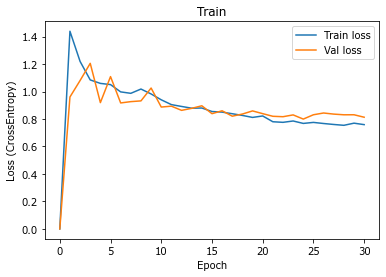

In [10]:
plt.plot(train_loss_list, label='Train loss')
plt.plot(val_loss_list, label='Val loss')
plt.title('Train')
plt.xlabel("Epoch")
plt.ylabel("Loss (CrossEntropy)")
#plt.ylim((0, 2))
plt.legend()  # 顯示標籤

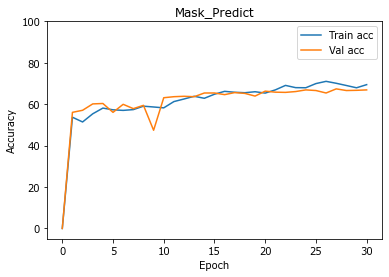

In [11]:
plt.plot(train_acc_list, label='Train acc')
plt.plot(val_acc_list, label='Val acc')
plt.title('Mask_Predict')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim((-5, 100))  # 限制範圍
plt.legend()  # 顯示標籤